## TFM3 Análisis avanzado de datos ##

Aunque en el Notebook TFM2 ya se han analizado practicamente todas las variables que influyen en el grado de satisfacción de los empleados, desempeño y porcentaje de abandono, en este Notebook, analizaremos en mas profundidad estos datos con una serie de herramientas que nos aportarán un mayor grado de detalle.

In [1]:
# Librerias de visualización y manipulación de datos
import pandas as pd
%pylab inline
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import missingno as msno

# matplotlib
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import Modelos algos.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

#preprocess.
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Imputer,LabelEncoder,OneHotEncoder

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Carga del Dataset DataSetRH3_tm.csv

datasetRH = pd.read_csv("./Data/DataSetRH3_tm.csv", delimiter=";")
datasetRH.head()

,Edad,Distancia_Casa,Genero,Estado,Id_empleado,Titulacion,Especializacion,Puesto,Departamento,Rol_laboral,...,Formacion_año_anterior,Años_sin_promocion,Años_Jefe_actual,ParticipacionLaboral,Conciliacion-Laboral-Personal,Calificacion_Desempeño,Satisfaccion_General,Satisfaccion_Personal,Satisfaccion_Laboral,Abandono
0,41,1,Mujer,Soltero,1,Tecnico,Fisicas,Tecnico,Operaciones & Desarrollo,Tecnico,...,0,0,5,Alta,Mala,Excelente,Media,Bajo,Muy Alta,Si
1,49,8,Hombre,Casado,2,FP,Mod. Informatica,Tecnico,Operaciones & Desarrollo,Consultor,...,3,1,7,Media,Muy Buena,Sobresaliente,Alta,Muy Alta,Media,No
2,37,2,Hombre,Soltero,4,Tecnico,Otros,Tecnico,Operaciones & Desarrollo,Analista-Prog,...,3,0,0,Media,Muy Buena,Excelente,Muy Alta,Media,Alta,Si
3,33,3,Mujer,Casado,5,Master,Fisicas,Tecnico,Operaciones & Desarrollo,Tecnico,...,3,3,0,Alta,Muy Buena,Excelente,Muy Alta,Alta,Alta,No
4,27,2,Hombre,Casado,7,FP,Mod. Informatica,Tecnico,Operaciones & Desarrollo,Tecnico,...,3,2,2,Alta,Muy Buena,Excelente,Baja,Muy Alta,Media,No


In [3]:
# revisamos la estructura del Dataset
datasetRH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
Edad                             1470 non-null int64
Distancia_Casa                   1470 non-null int64
Genero                           1470 non-null object
Estado                           1470 non-null object
Id_empleado                      1470 non-null int64
Titulacion                       1470 non-null object
Especializacion                  1470 non-null object
Puesto                           1470 non-null object
Departamento                     1470 non-null object
Rol_laboral                      1470 non-null object
Antiguedad_empresa               1470 non-null int64
Antiguedad_puesto                1470 non-null int64
Frecuencia_Viajes                1470 non-null object
Ingresos_mensuales               1470 non-null int64
Tarifa_hora                      1470 non-null int64
Tarifa_Mes                       1470 non-null int64
Tarifa_Diaria                    1470

In [4]:
# Hacemos una copia de la base de datos datasetRH que denominaremos datasetRH2.
datasetRH2 = datasetRH.copy()

## Relación edad, ingresos mensuales y grado de abandono
Tal y como hemos visto anteriormente la edad y los ingresos mensuales son las características que están mas relacionados con el grado de abandono. La relación no es lineal, ya que afecta solo a un rango de valores de la edad y de los ingresos mensuales.
Con una gráfica plt scatter vamos a ver de forma gráfica donde se acumula el grado de abandono relacionándolo con la edad y los ingresos.

In [5]:
# Hacemos numérica la variable abandono
datasetRH.replace({'Abandono' : {'Si': 1, 'No': 0}}, inplace=True)

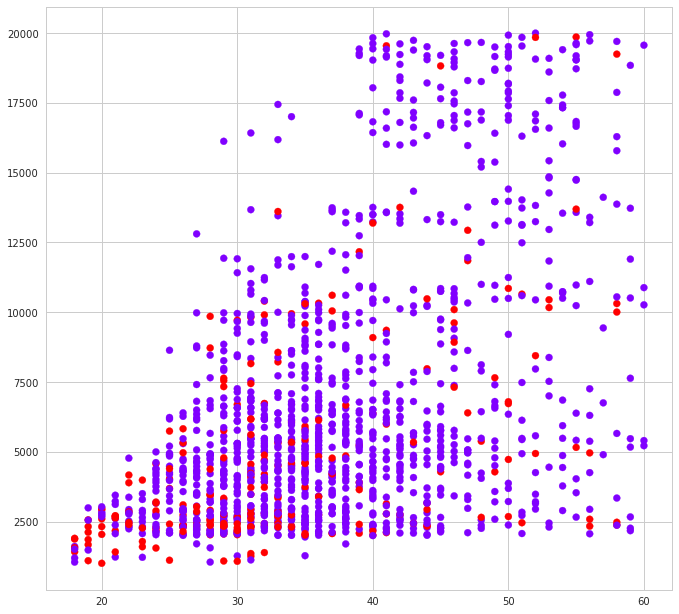

In [6]:
X = datasetRH[["Edad","Ingresos_mensuales"]].values
y = datasetRH["Abandono"]
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1],c=y,cmap="rainbow")
plt.show()

** Análisis:** Como podemos apreciar el grado de abandono se concentra en el rango bajo salarial entre 2.000 y 5.000, asi como en el rango de edad de 20 a 40 años. De esta forma podemos ver como afecta la edad y los ingresos mensuales al porcetaje de abandono. 

** Cálculo de la entropía:** Otra forma de analizar esta información es calculando la entropía que la podemos considerar como la distribución de las similaridades o la forma de organización y orden de los datos en el espacio de n-dimensiones. De esta forma podemos ver la dependencia de estas tres variables.

In [7]:
def entropy(attribute_data):
    _, val_freqs = np.unique(attribute_data, return_counts=True)
    val_probs = val_freqs / float(len(attribute_data))
    return -val_probs.dot(np.log(val_probs))

In [8]:
def cut_df(df,feature,percentile):
    return (df[feature].sort_values().iloc[:int(len(df)*percentile/100)].index,
            df[feature].sort_values().iloc[int(len(df)*percentile/100):].index)

def entropy_gain(df,feature,percentile):
    left,right = cut_df(df,feature,percentile)
    return entropy(df["Abandono"]) \
         - entropy(df["Abandono"].loc[left])*percentile/100 \
         - entropy(df["Abandono"].loc[right])*(100-percentile)/100

In [9]:
entropy(datasetRH["Abandono"])

0.4416947962009027

**Análisis:** La entropía de la variable abandono es alta, debido a que la distribición no es homogenea o lineal. Vamos a seguir analizando pero ahora vamos a añadir las variables edad e ingresos mensuales.

0.01653227895559889


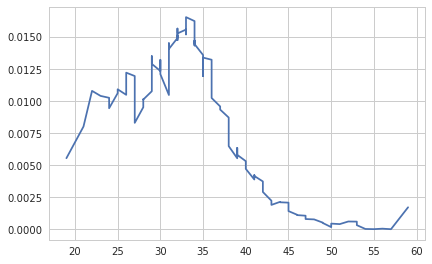

In [10]:
feature = "Edad"
gains = [entropy_gain(datasetRH,feature,i) for i in range(1,100)]
values = [datasetRH[feature].sort_values().iloc[int(len(datasetRH)*i/100)] 
          for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

In [11]:
# Vamos a centrarnos en el intervalo de 0 - 37 años
df_left = datasetRH[datasetRH["Edad"]<=37]

0.01514593758714744


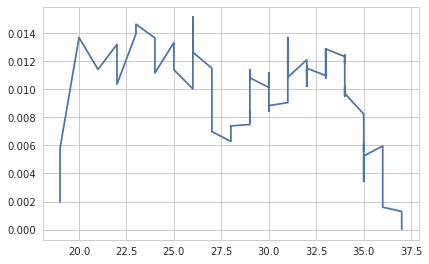

In [12]:
feature = "Edad"
gains = [entropy_gain(df_left,feature,i) for i in range(1,100)]
values = [df_left[feature].sort_values().iloc[int(len(df_left)*i/100)] for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

**Análisis:** Al centarnos en el intervalo donde mas relación hay entre la edad y el grado de abandono la entropia baja.

0.020501051973648488


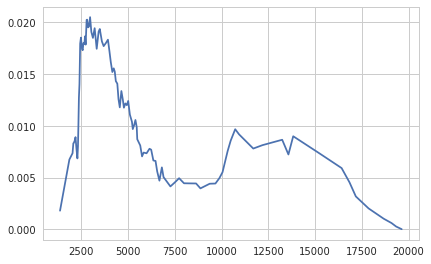

In [13]:
feature = "Ingresos_mensuales"
gains = [entropy_gain(datasetRH,feature,i) for i in range(1,100)]
values = [datasetRH[feature].sort_values().iloc[int(len(datasetRH)*i/100)] 
          for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

In [14]:
# Vamos a centrarnos en el intervalo de ingresos de 0 - 5,000
df_left = datasetRH[datasetRH["Ingresos_mensuales"]<=5000]

0.019654533128070972


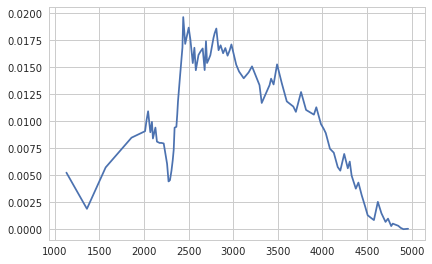

In [15]:
feature = "Ingresos_mensuales"
gains = [entropy_gain(df_left,feature,i) for i in range(1,100)]
values = [df_left[feature].sort_values().iloc[int(len(df_left)*i/100)] for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

**Análisis:** En el caso de los ingresos mensuales la entropía es menor que en el caso de la edad. Podemos considerar que el grado de abandono esta mas relacionado con la edad que con los Ingresos mensuales.

## Modelado (Técnica sobremuestreo)
Para esta primera parte del modelado, lo realizaremos sobre el dataset datasetRH2.

Hacemos numericas las variables que queremos incluir en el análisis.

In [16]:
datasetRH2.replace({'Abandono': {'Si': 1, 'No': 2}},  inplace = True)
datasetRH2.replace({'Genero': {'Mujer': 1, 'Hombre': 2}},  inplace = True)
datasetRH2.replace({'Departamento': {"Ventas": 1, "Operaciones & Desarrollo": 2,"Recursos Humanos": 3}},  inplace = True)
datasetRH2.replace({'ParticipacionLaboral': {1: "Baja", 2: "Media",3: "Alta", 4: "Muy Alta"}},  inplace = True)
datasetRH2.replace({'Conciliacion-Laboral-Personal': {"Mala": 1, "Buena": 2,"Muy Buena": 3, "Optima": 4}},  inplace = True)
datasetRH2.replace({'Calificacion_Desempeño': {"Baja": 1, "Buena": 2,"Excelente": 3, "Sobresaliente": 4}},  inplace = True)
datasetRH2.replace({'Satisfaccion_General': {"Baja": 1, "Media": 2,"Alta": 3, "Muy Alta": 4}},  inplace = True)
datasetRH2.replace({'Satisfaccion_Personal': {"Baja": 1, "Media": 2,"Alta": 3, "Muy Alta": 4}},  inplace = True)
datasetRH2.replace({'Satisfaccion_Laboral': {"Baja": 1, "Media": 2,"Alta": 3, "Muy Alta": 4}},  inplace = True)

Eliminamos las variables que hemos visto que no son criticas, ni están relacionadas con el resto de variables

In [17]:
datasetRH2=datasetRH2.drop(['Titulacion', 'Estado','Especializacion',
                     'Frecuencia_Viajes','Rol_laboral','Puesto' ,'Horas-extras',
                            'ParticipacionLaboral','Satisfaccion_Personal'], axis=1)

Para la preparación de conjunto de datos comenzaremos con la codificación de características

Se utiliza el codificador de etiquetas de la biblioteca de scikit para codificar todas las características categóricas.

In [18]:
def transform(feature):
    le=LabelEncoder()
    df[feature]=le.fit_transform(df[feature])
    print(le.classes_)


***Característica de escalado.***

La biblioteca de scikit proporciona varios tipos de escaladores, incluidos MinMax Scaler y StandardScaler. A continuación, se utilizará el StandardScaler para escalar los datos.

In [19]:
scaler=StandardScaler()
scaled_df=scaler.fit_transform(datasetRH2.drop('Abandono',axis=1))
X=scaled_df
Y=datasetRH2['Abandono'].as_matrix()

Se dividen los datos en conjuntos de entrenamiento y validación.

In [20]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

Para el caso del grado de abandono tenemos un conjunto de datos con predominio del Si (84 %) sobre el No (16 %).

Para poder trabajar con un conjunto de datos tan poco equilibrado tenemos que tomar ciertas medidas, de lo contrario, el rendimiento de nuestro modelo puede verse significativamente afectado. 

Para ello se ha utilizado la técnica de sobremuestreo conocida como SMOTE (Técnica de sobremuestreo de minorías sintéticas) que crea aleatoriamente algunos casos 'sintéticos' de la clase minoritaria para que las observaciones netas de ambas clases se equilibren.


In [21]:
oversampler=SMOTE(random_state=42)
x_train_smote,  y_train_smote = oversampler.fit_sample(x_train,y_train)

Un dato que debemos tener en cuenta es que la precisión no es una buena opción. Esto se debe a que, dado que los datos están sesgados, incluso un algoritmo que clasifica el objetivo como el que pertenece a la clase mayoritaria en todo momento logrará una precisión muy alta.
Por lo tanto, en este tipo de casos podemos usar otras métricas como:

- Precision: que equivale a (verdaderos positivos) / (verdaderos positivos + falsos positivos)

- Recall: equivale a (verdaderos positivos) / (verdaderos positivos + falsos negativos)

- Accuracy: el significado armónico de precision y recall

- AUC ROC: la curva ROC es una gráfica entre recall y precision

En esta sección, se han usado diferentes modelos de la biblioteca de scikit y los se han entrenado en los datos previamente muestreados y luego se han utilizado cumplir los propósitos de predicción.

In [22]:
def compare(model):
    clf=model
    clf.fit(x_train_smote,y_train_smote)
    pred=clf.predict(x_test)
    
    # Calculamos varias métricas
    
    acc.append(accuracy_score(pred,y_test))
    prec.append(precision_score(pred,y_test))
    rec.append(recall_score(pred,y_test))
    auroc.append(roc_auc_score(pred,y_test))  

In [23]:
acc=[]
prec=[]
rec=[]
auroc=[]
models=[SVC(kernel='rbf'),RandomForestClassifier(),GradientBoostingClassifier()]
model_names=['rbfSVM','RandomForestClassifier','GradientBoostingClassifier']

for model in range(len(models)):
    compare(models[model])
    
d={'Modelling Algo':model_names,'Accuracy':acc,'Precision':prec,'Recall':rec,'Area Under ROC Curve':auroc}
met_df=pd.DataFrame(d)
met_df

,Accuracy,Area Under ROC Curve,Modelling Algo,Precision,Recall
0,0.801630,0.603253,rbfSVM,0.395833,0.301587
1,0.771739,0.547649,RandomForestClassifier,0.270833,0.209677
2,0.850543,0.652854,GradientBoostingClassifier,0.312500,0.405405


Comparando diferentes modelos

In [24]:
def comp_models(met_df,metric):
    sns.factorplot(data=met_df,x=metric,y='Modelling Algo',size=5,aspect=1.5,kind='bar')
    sns.factorplot(data=met_df,y=metric,x='Modelling Algo',size=7,aspect=2,kind='point')

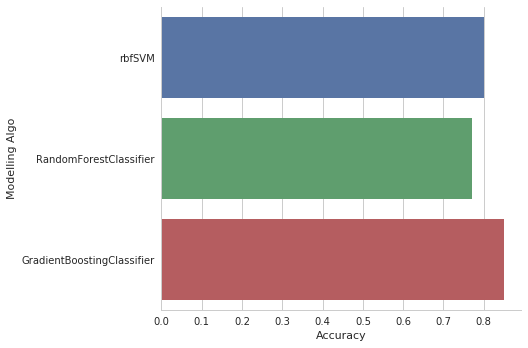

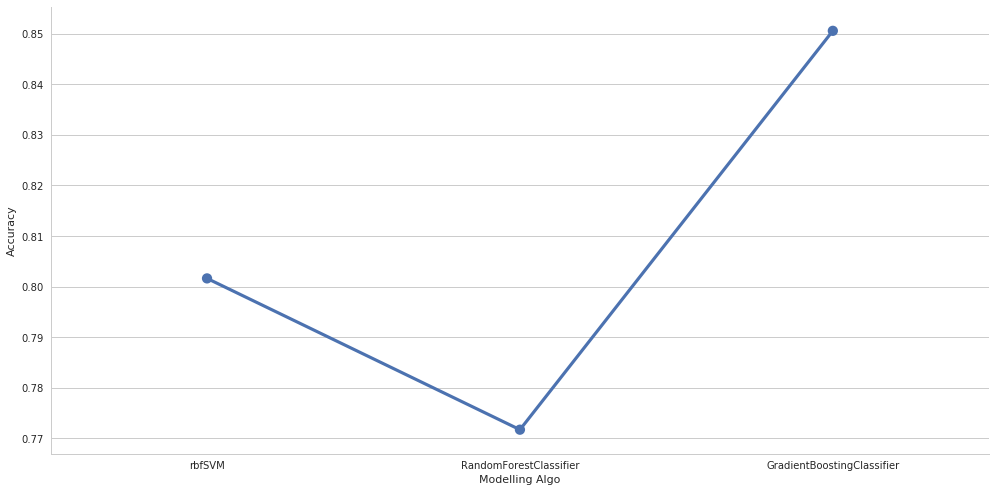

In [25]:
comp_models(met_df,'Accuracy')

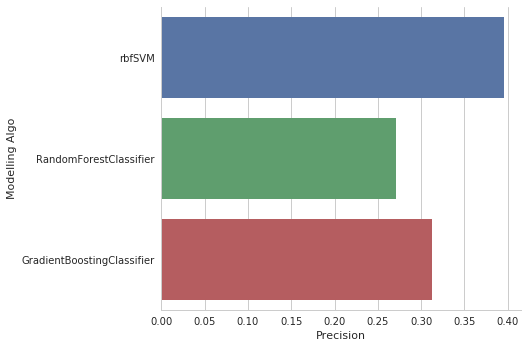

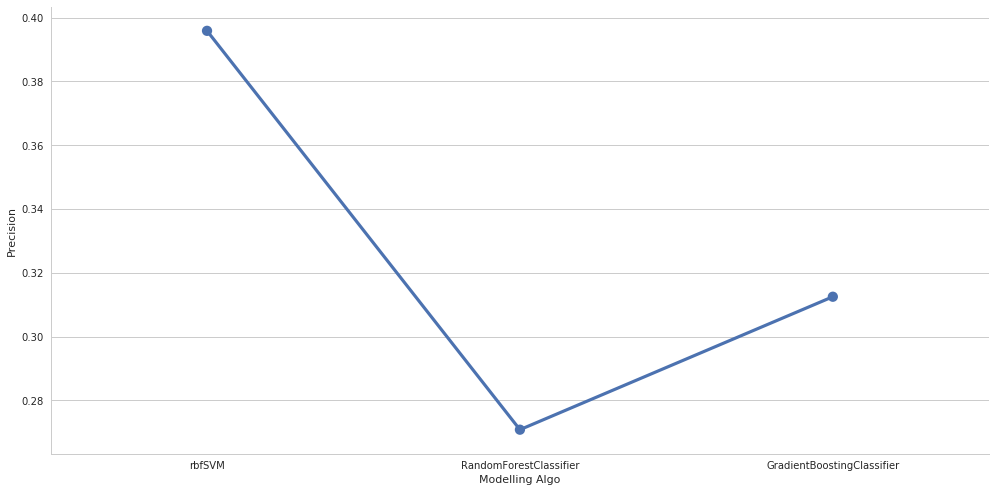

In [26]:
comp_models(met_df,'Precision')

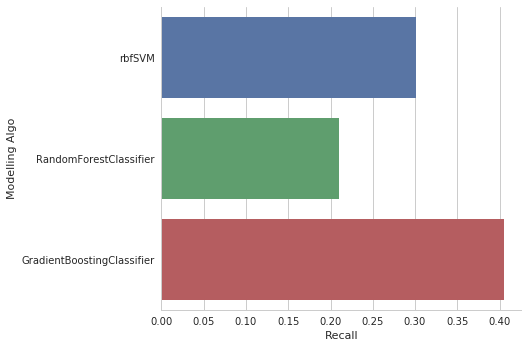

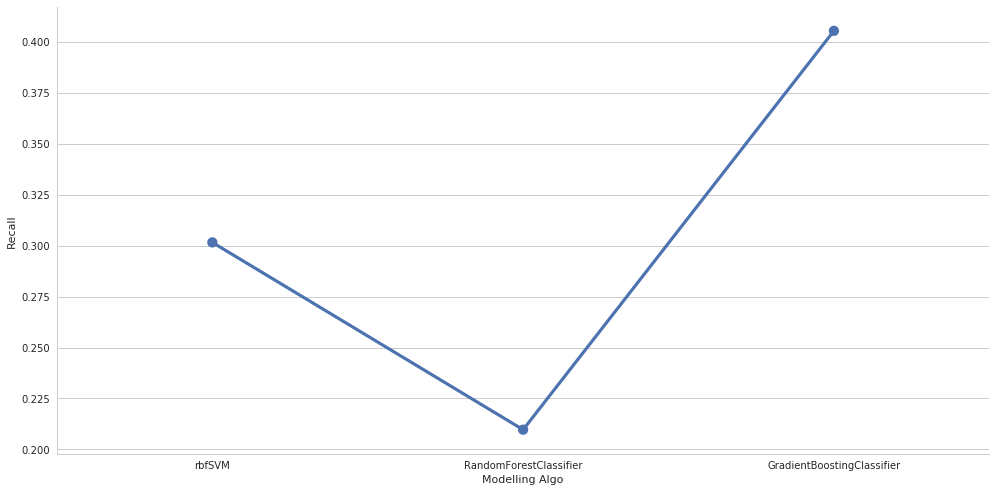

In [27]:
comp_models(met_df,'Recall')

** Conclusiones **

Después de entrenar diferentes modelos con el conjunto de datos datasetRH2, podemos observar que el modelo rbfSVM es el que tiene mayor precisión y recall.

## Análisis de Varianza (ANOVA)

In [28]:
#Añadimos una serie de librerias que necesitamos
from pandas import DataFrame
from sklearn import preprocessing
import math
import seaborn as sns
from ggplot import *
import itertools
import sklearn.metrics
from sklearn.metrics import accuracy_score, log_loss, classification_report

Por último, para analizar la calidad de nuestras características para predecir el Abandono, realizaremos un análisis de la varianza (ANOVA), de esta forma evaluaremos el poder predictivo de nuestras características. El resultado de la prueba consta de dos valores:

- El ** estadístico de Fisher (F) **, que es la relación entre las variaciones en las medias muestrales y las variaciones dentro de las muestras. Una característica que obtiene un gran valor de F implica que gran parte de ella se ve afectada en la variable objetivo "Abandono".

    El ** valor p **, que es la probabilidad de observar dicha distribución dado que dos variables son independientes. En nuestro caso, queremos minimizar el valor p.

Generalmente, en dicho análisis, decidiremos un umbral arbitrario α eso determinará si una característica pasó la prueba o no. Elegiremos un nivel de confianza de 1 − α = 95%, lo que significa que rechazaremos todos los resultados por encima de esta probabilidad, considerando que muy poca de la variación de la variable objetivo puede explicarse por la variación de una característica particular.

In [29]:
X, y = pd.get_dummies(datasetRH.iloc[:, 1:].copy()), datasetRH.iloc[:, 0].copy()

In [30]:
from sklearn.model_selection import train_test_split

# Train / Test split (tamaño de conjunto de entrenamiento: 75 %)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = X_train.copy(); X_test = X_test.copy()
X_train["Ingresos_mensuales"] = scaler.fit_transform(X_train[["Ingresos_mensuales"]])[:,0]
X_test["Ingresos_mensuales"] = scaler.transform(X_test[["Ingresos_mensuales"]])[:, 0]

In [32]:
from sklearn.feature_selection import SelectKBest
alpha = .1

np.random.seed(42)  
anova_filter = SelectKBest()
anova_filter.fit(X_train, y_train)

anova_scores = pd.DataFrame(index=X.columns)

anova_scores["Fisher"] = anova_filter.scores_
anova_scores["p-value"] = anova_filter.pvalues_
anova_scores = anova_scores.sort_values("Fisher", ascending=False)
selected_features = list(anova_scores.loc[anova_scores["p-value"] < 1 - alpha, :].index)
if len(selected_features) == X.shape[1]:
    print("No discarded feature")
X = X[selected_features]
anova_scores.style.apply(lambda f: ["color: red"] * 2 if f["p-value"] > 1-alpha else ["color: black"]*2, axis=1)

,Fisher,p-value
Años_trabajados,24.2125,1.99054e-125
Ingresos_mensuales,9.91152,1.19633e-51
Rol_laboral_Desarrollador,5.70184,5.95829e-26
Puesto_Gerente,5.11942,2.44138e-22
Rol_laboral_Gerente,5.11942,2.44138e-22
Puesto_Tecnico,4.93606,3.32139e-21
Antiguedad_empresa,4.49399,1.74309e-18
Titulacion_FP,3.8696,1.07054e-14
Empleos_anteriores,3.73475,6.84699e-14
Especializacion_Mod. Informatica,3.15415,1.69671e-10


**Conclusiones:** Como se puede ver en la matriz de correlación anterior, podemos apreciar que las variables Años trabajados e ingresos mensuales son las que mas relacionadas están con el porcentaje de abandono. Mediante esta técnica podemos considerar que son las variables mas fiables para poder basarnos en futuras predicciones.